<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Library-installed" data-toc-modified-id="Library-installed-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Library installed</a></span></li><li><span><a href="#Functions-and-Stats-modules" data-toc-modified-id="Functions-and-Stats-modules-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions and Stats modules</a></span><ul class="toc-item"><li><span><a href="#Distance-metrics" data-toc-modified-id="Distance-metrics-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Distance metrics</a></span></li><li><span><a href="#Initial-patch-sampler-and-selector." data-toc-modified-id="Initial-patch-sampler-and-selector.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Initial patch sampler and selector.</a></span></li><li><span><a href="#iterate-through-image-list-wrapper." data-toc-modified-id="iterate-through-image-list-wrapper.-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>iterate through image list wrapper.</a></span></li><li><span><a href="#GCLM-specific-functions;-patch-wrapper-and-stats-function" data-toc-modified-id="GCLM-specific-functions;-patch-wrapper-and-stats-function-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>GCLM specific functions; patch wrapper and stats function</a></span></li></ul></li><li><span><a href="#Data-set-analysis" data-toc-modified-id="Data-set-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data set analysis</a></span></li></ul></div>

# Library installed

In [16]:
import random
import math
import numpy as np
import pandas as pd
import cv2 
import pickle
from scipy import misc
from scipy import ndimage
import os
import glob
from sklearn.feature_extraction import image
from PIL import Image
import imageio
from skimage.feature import greycomatrix, greycoprops
from math import*
from scipy import spatial
from timeit import default_timer as timer
import matplotlib.pyplot as plt

In [2]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 364B-7A6D

 Directory of C:\Users\niall\OneDrive\Documents\Data science masters\Thesis\Scripts\Python\Texture GCLM

10/09/2019  00:20    <DIR>          .
10/09/2019  00:20    <DIR>          ..
09/09/2019  19:05    <DIR>          .ipynb_checkpoints
19/08/2019  01:32            13,586 GCLM procedure.docx
10/09/2019  00:20         4,213,846 GCLM_texture_patch_small_scale_sampling.ipynb
05/09/2019  23:47           643,705 Texture extraction.ipynb
09/09/2019  00:22           428,701 Texture_features_EDA.ipynb
               4 File(s)      5,299,838 bytes
               3 Dir(s)  35,374,297,088 bytes free


# Functions and Stats modules

## Distance metrics

In [17]:
def Rand(start, end, num): 
    """Produce list of random number"""
    res_orig=[]
    
    for i in range(num):
        res = [] 
        for j in range(num): 
            res.append(random.randint(start, end)) 
        res_orig.append(res)
    
    return res_orig


def euclidean_distance(x,y):
    #Determine euclidean distance between vector 
    return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))



In [18]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
# sum of the squared difference between the two images;
# NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    
# return the MSE, the lower the error, the more "similar"
# the two images are
    return err

In [19]:
def mse_patch_chk(patch_list,trl_patch,Thresh):
    """The purpose of this method is to assess a patch for cosine similarity between batches"""
    #Iterating through patch list to estimate whether or not patch matches 
    if len(patch_list)==0:
        _y= True
    else:
        #Iterate through patches in patch list for analysis
        _y=True
        for ret_pat in patch_list:
            #Getting cosine similarity between patches
            thresh_chk=mse(ret_pat,trl_patch)
            #If similarity is two high then drop patch for analysis 
            if thresh_chk<Thresh:
                #print('Threshold not met:',thresh_chk)
                _y=False
                break
    return _y 

In [20]:
def cos_sim(arr1,arr2):
    """the purpose of this method is to assess cosine similarity between arrays that are non zeros"""
    #Merging arrays and removing zero rows for analysis 
    new_array=np.concatenate((arr1,arr2),axis=1)
    #Remove zero arrays
    new_array=new_array[~np.all(new_array==0,axis=1)]
    #split array back into regular array
    arr_set=np.split(new_array,2,axis=1)
    #return cosine similarity of non zero arrays 
    return 1-spatial.distance.cosine(arr_set[1].flatten('F'),arr_set[0].flatten('F'))
    

## Initial patch sampler and selector. 

In [21]:
def rem_sim_patches(patch_list,
                    patch_chk,threshold,
                    sample_size_perc=0.02):
    """The purpose of this method is to reduce the number of patches in the patch list down to a small number
    based on initial intensity pattern patching based on a similarity metric."""
    return_array=[]
    patch_index=[]
    #Counter index to iterate through patch list.
    cntr_idx=0
    #generating random index list for performance later on . 
    random_index=random.sample(range(0, patches.shape[0]), patches.shape[0]) 
    #Getting overall sample size to sample from. 
    sample_size=round(patch_list.shape[0]*sample_size_perc)
    #Iterating through list for 
    while (sample_size>0) and (cntr_idx<(len(patch_list)-2)):
        
        #Iterathing through each patch in patch list 
        trl_patch=patch_list[random_index[cntr_idx]]
        cntr_idx+=1
        #Seeing iteration number through system 
        #if cntr_idx%1000==0:
         
            #print('counter index:',cntr_idx)
            
            #If patch is not entirely black and is not overly similar to other intensity values sets. 
        if np.all(trl_patch==0):
            #print()
            continue
        elif patch_chk(return_array,trl_patch,threshold)==False:
            #print('mse patch check elif',patch_chk(return_array,trl_patch,threshold))
            continue
        else:
            #print('mse patch check else',patch_chk(return_array,trl_patch,threshold))
            return_array.append(trl_patch)
            #returning index for ensuring appropriate labels are acquired for specific segmented section of image. 
            patch_index.append(random_index[cntr_idx])
            sample_size-=1

    return (return_array,patch_index)        

In [45]:
def samp_mask(patch_list,patch_mask_list,
              mask_intensity,sample_size_perc=0.005):
    """The purpose of this method is to reduce the number of patches in the patch list down to a small number
    based on initial intensity pattern patching based on a similarity metric."""
    return_array=[]
    patch_index=[]
    grnd_array=[]
    #Counter index to iterate through patch list.
    cntr_idx=0
    print('patch list size',patch_list.shape)
    print('mask list size',patch_mask_list.shape)
    #generating random index list for performance later on . 
    random_index=random.sample(range(0, patch_list.shape[0]-1), patch_list.shape[0]-1) 
    #Getting overall sample size to sample from. 
    sample_size=round(patch_list.shape[0]*sample_size_perc)
    #Iterating through list for 
    while (sample_size>0) and (cntr_idx<(len(patch_list)-2)):
        
        #Iterathing through each patch in patch list 
        trl_patch=patch_mask_list[random_index[cntr_idx]]
        cntr_idx+=1
            #If patch is not entirely black and is not overly similar to other intensity values sets. 
        if np.all(trl_patch==mask_intensity):
            print('patch_intensites:',np.unique(trl_patch,return_counts=True))
            print('mask intensity_required:',mask_intensity)
            patch_index.append(random_index[cntr_idx])
            return_array.append(patch_list[random_index[cntr_idx]])
            grnd_array.append(patch_mask_list[random_index[cntr_idx]])
            sample_size-=1
        else:
            #print('mse patch check else',patch_chk(return_array,trl_patch,threshold))
            continue
            #returning index for ensuring appropriate labels are acquired for specific segmented section of image.
    return (return_array,patch_index)        

In [23]:
def bytescaling(data, cmin=None, cmax=None, high=255, low=0):
    """
    Converting the input image to uint8 dtype and scaling
    the range to ``(low, high)`` (default 0-255). If the input image already has 
    dtype uint8, no scaling is done.
    :param data: 16-bit image data array
    :param cmin: bias scaling of small values (def: data.min())
    :param cmax: bias scaling of large values (def: data.max())
    :param high: scale max value to high. (def: 255)
    :param low: scale min value to low. (def: 0)
    :return: 8-bit image data array
    """
    if data.dtype == np.uint8:
        return data

    if high > 255:
        high = 255
    if low < 0:
        low = 0
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(np.uint8)

In [24]:
def get_cntrl_mask_pixel(grnd_patches,window_size,random_idx):
    """the purpose of this method is to perform indexing slicing on the ground mask patches
    to return the labels associated with subsampled section of the images."""
    cntrl_idx=int((window_size[0]-1)-(window_size[0]-1)/2)
    
    return grnd_patches[random_idx,cntrl_idx,cntrl_idx]

## iterate through image list wrapper.

In [25]:
os.chdir(r'C:\Users\niall\OneDrive\Documents\Data science masters\Thesis\Results\EDA\gnrl_info')

#file_list=glob.glob('*.png')

In [26]:
angles=[0,45,90,135]
#Radians values for grey co-occurence matrix. 
angles_radian=[(angs*np.pi)/180 for angs in angles]
unused_angles=[180,225,270,315,360]
angles=[0,45,90,135]
#Radians values for grey co-occurence matrix. 
#angles_radian=[(angs*np.pi)/180 for angs in angles]

In [4]:
angles_radian

[0.0, 0.7853981633974483, 1.5707963267948966, 2.356194490192345]

In [27]:
gnrl_pic_info=pd.read_excel('gnrl_raw_data_info.xlsx')


In [6]:
gnrl_pic_info.columns

Index(['Unnamed: 0', 'TransferSyntaxUID', 'SOPClassUID', 'SOPInstanceUID',
       'StudyDate', 'SeriesDate', 'AcquisitionDate', 'ContentDate',
       'StudyTime', 'SeriesTime', 'AcquisitionTime', 'ContentTime', 'Modality',
       'Manufacturer', 'InstitutionName', 'StudyDescription',
       'SeriesDescription', 'PatientName', 'PatientID', 'PatientBirthDate',
       'PatientSex', 'PatientAge', 'PatientWeight', 'SliceSpacing',
       'StudyInstanceUID', 'SeriesInstanceUID', 'SeriesNumber',
       'AcquisitionNumber', 'InstanceNumber', 'ImagePositionPatient',
       'ImageOrientationPatient', 'SamplesPerPixel', 'Rows', 'Columns',
       'PixelSpacing', 'BitsAllocated', 'BitsStored', 'HighBit',
       'PixelRepresentation', 'PixelData', 'shape', 'sampling', 'Image_type',
       'MR_modes', 'Person_id', 'File_location', 'File_name', 'Slice_id',
       'Mode'],
      dtype='object')

In [28]:
gnrl_pic_info_sel=gnrl_pic_info.loc[:,['Image_type','MR_modes', 'Person_id', 'File_location',
                                       'File_name', 'Slice_id','Mode']]
No_pers=gnrl_pic_info_sel['Person_id'].unique()
No_image_type=gnrl_pic_info_sel['Image_type'].unique()


In [9]:
trl_img=gnrl_pic_info_sel['File_location'][0]

'C:\\Users\\niall\\OneDrive\\Documents\\Data science masters\\Thesis\\Biomedical images\\CHAOS_Train_Sets\\unpreproc\\MR\\1\\T1DUAL\\DICOM_anon\\InPhase\\IMG-0004-00002.dcm'

In [15]:
os.chdir(r'C:\Users\niall\OneDrive\Documents\Data science masters\Thesis\Results\Texture Results\GCLM data run3')

In [41]:
pwd

'C:\\Users\\niall\\OneDrive\\Documents\\Data science masters\\Thesis\\Results\\EDA\\gnrl_info'

In [64]:
#angles values 
unused_angles=[180,225,270,315,360]
angles=[0,45,90,135]
#Radians values for grey co-occurence matrix. 
angles_radian=[(angs*np.pi)/180 for angs in angles]
#Take find 
#offsets
offsets=[[0],[1],[2]] #[1],,[3]]


#Iterating through people
    #Iterating through different image types
for img_patches in file_list:

    if img_types=='Ground':
        continue
    else:
        Slice_info=gnrl_pic_info_sel[(gnrl_pic_info_sel['Person_id']==people) & (gnrl_pic_info_sel['Image_type']==img_types)]
        Mode=Slice_info['MR_modes'].unique()
        Ground_info=gnrl_pic_info_sel[(gnrl_pic_info_sel['Person_id']==people) & (gnrl_pic_info_sel['Image_type']=='Ground')&(gnrl_pic_info_sel['MR_modes']==Mode[0])]
        No_slices=Ground_info['Slice_id'].unique()
        Samp_no_slc=round(No_slices.shape[0]*0.05)
        rand_slice_no=random.sample(range(1,(No_slices.shape[0]-1)),Samp_no_slc)


        #Iterating through ground for analysis
        for slc_no in rand_slice_no:
            img_orig=Slice_info['File_location'][Slice_info['Slice_id']==slc_no]
            img_grnd=Ground_info['File_location'][Ground_info['Slice_id']==slc_no]
            print(img_orig)
            print(img_grnd)
             #Perform texture feature analysis for each slice
            #gen_text_gclm(window_size,
             #             angles_radian,
              #            offsets,
               #           (img_orig,img_grnd),
                #          [people,img_types,slc_no])

                             #Perform texture feature analysis for each slice
            gen_org_patches(window_size,
                          angles_radian,
                          offsets,
                          (img_orig,img_grnd),
                          [people,img_types,slc_no])
            
               

840    C:\Users\niall\OneDrive\Documents\Data science...
Name: File_location, dtype: object
892    C:\Users\niall\OneDrive\Documents\Data science...
Name: File_location, dtype: object
patch list size (78400, 9, 9)
mask list size (78400, 9, 9)


c:\users\niall\anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:288: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], 

patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_inte

patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_requ

patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_requ

patch_intensites: (array([252], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 252
patch_intensites: (array([252], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 252
patch_intensites: (array([252], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 252
829    C:\Users\niall\OneDrive\Documents\Data science...
Name: File_location, dtype: object
881    C:\Users\niall\OneDrive\Documents\Data science...
Name: File_location, dtype: object
patch list size (78400, 9, 9)
mask list size (78400, 9, 9)
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int6

patch list size (78400, 9, 9)
mask list size (78400, 9, 9)
patch list size (78400, 9, 9)
mask list size (78400, 9, 9)
830    C:\Users\niall\OneDrive\Documents\Data science...
Name: File_location, dtype: object
882    C:\Users\niall\OneDrive\Documents\Data science...
Name: File_location, dtype: object
patch list size (78400, 9, 9)
mask list size (78400, 9, 9)
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], d

patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], 

patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_inte

patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_requ

patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_requ

patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch list size (78400, 9, 9)
mask list size (78400, 9, 9)
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64

patch list size (78400, 9, 9)
mask list size (78400, 9, 9)
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], 

patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_requ

mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
pat

patch list size (78400, 9, 9)
mask list size (78400, 9, 9)
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], 

patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_requ

patch list size (78400, 9, 9)
mask list size (78400, 9, 9)
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array

patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_requ

patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_requ

855    C:\Users\niall\OneDrive\Documents\Data science...
Name: File_location, dtype: object
881    C:\Users\niall\OneDrive\Documents\Data science...
Name: File_location, dtype: object
patch list size (78400, 9, 9)
mask list size (78400, 9, 9)
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask int

patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], 

patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch list size (78400, 9, 9)
mask list size (78400, 9, 9)
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81],

patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_requ

patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_requ

patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 0
patch_intensites: (array([0], 

patch list size (78400, 9, 9)
mask list size (78400, 9, 9)
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], 

patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_requ

patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_intensites: (array([63], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 63
patch_inte

patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 126
patch_intensites: (array([126], dtype=uint8), array([81], dtype=int64))
mask intensity_requ

patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_required: 189
patch_intensites: (array([189], dtype=uint8), array([81], dtype=int64))
mask intensity_requ

KeyboardInterrupt: 

In [63]:
def gen_org_patches(window_size,angles_radian,offsets,file_list,file_info):
    
    """The purpose of this method is to act as a wrapper to generate a table of info on file"""
    #Ground Image
    one_image=bytescaling(imageio.imread(file_list[0].iloc[0]))#
    img_name=os.path.basename(file_list[0].iloc[0])
    img_name=os.path.splitext(img_name)[0]
    #Additoinal code here on file information required  
    grnd_img=imageio.imread(file_list[1].iloc[0])
    #iterating through different window size for estimating performance. 
    mask_intensities={0:'Background',63:'Liver',126:'r_kidney',189:'l_kidney',252:'spleen'}#,,

    for windows in window_size:

        patches=image.extract_patches_2d(one_image,windows)
        #print(patches.shape)
        grnd_patches=image.extract_patches_2d(grnd_img,windows)
        #print(grnd_patches.shape)
        
        for mask_intensity in mask_intensities:
            
            org_spec_patches,patch_idx=samp_mask(patches,grnd_patches,mask_intensity,sample_size_perc=0.001)
            cntr=10
            for idx,vals in enumerate(org_spec_patches):
                
                org=str(mask_intensities[mask_intensity])
                patch_id=str(patch_idx[idx-1])
                rand_no=str(random.randint(1,5000))
                file_name=org+'_'+patch_id+'img_name'+img_name+'.jpg'
                imageio.imwrite(file_name,vals)
                
                if cntr==0:
                    break    
                cntr-=1

In [56]:
img_orig.iloc[0]

'C:\\Users\\niall\\OneDrive\\Documents\\Data science masters\\Thesis\\Biomedical images\\CHAOS_Train_Sets\\unpreproc\\MR\\2\\T1DUAL\\DICOM_anon\\InPhase\\IMG-0010-00002.dcm'

In [67]:
img_grnd.iloc[0]

'C:\\Users\\niall\\OneDrive\\Documents\\Data science masters\\Thesis\\Biomedical images\\CHAOS_Train_Sets\\unpreproc\\MR\\2\\T1DUAL\\Ground\\IMG-0010-00020.png'

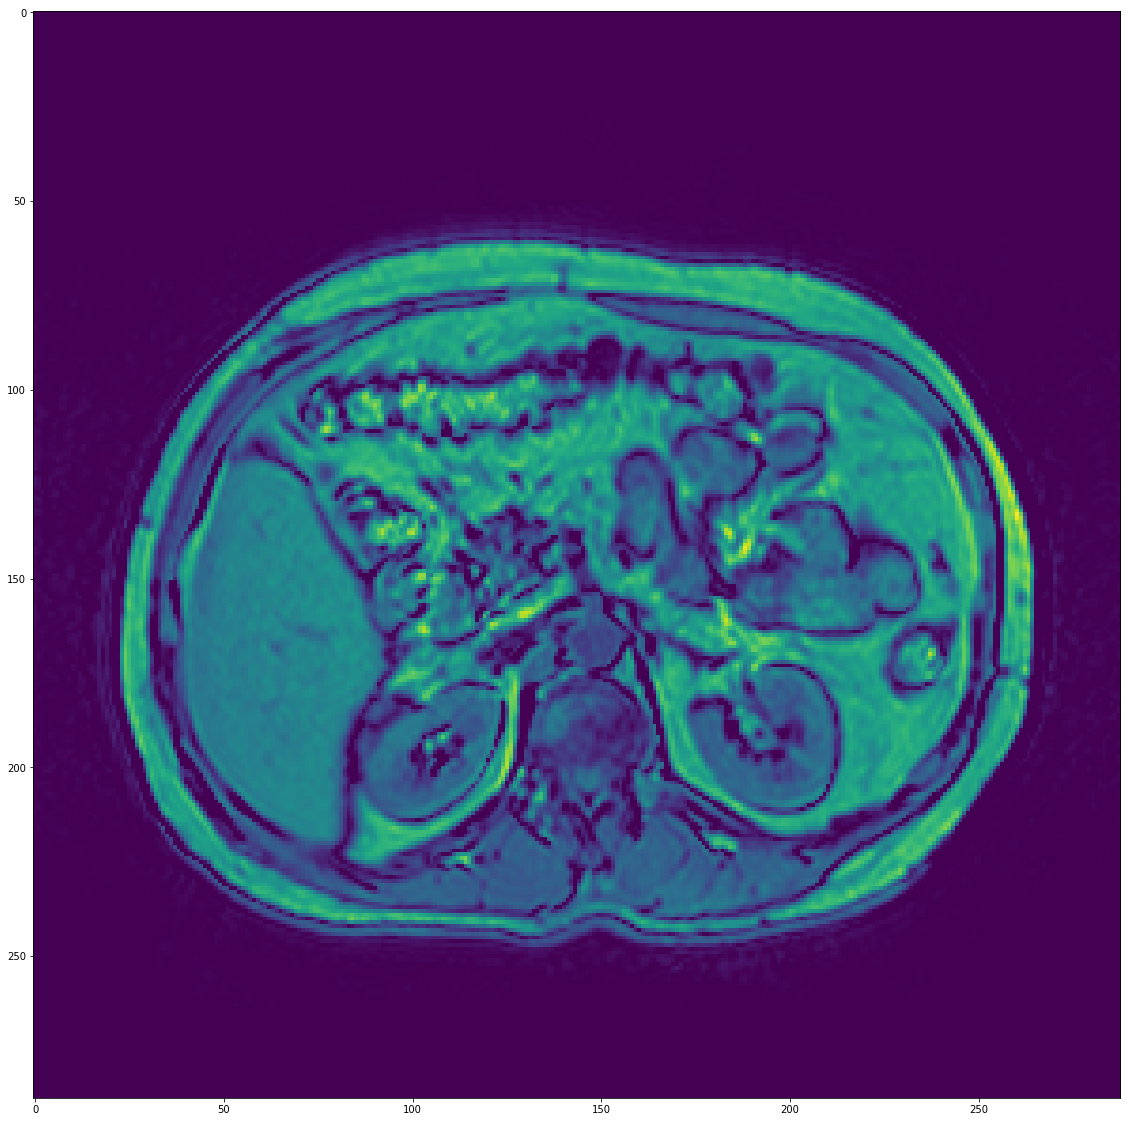

In [70]:
trl_orig=imageio.imread(img_orig.iloc[0])
plt.figure(figsize=(20,20))
plt.imshow(trl_orig)

In [68]:
img_orig.iloc[0]

'C:\\Users\\niall\\OneDrive\\Documents\\Data science masters\\Thesis\\Biomedical images\\CHAOS_Train_Sets\\unpreproc\\MR\\2\\T1DUAL\\DICOM_anon\\OutPhase\\IMG-0010-00019.dcm'

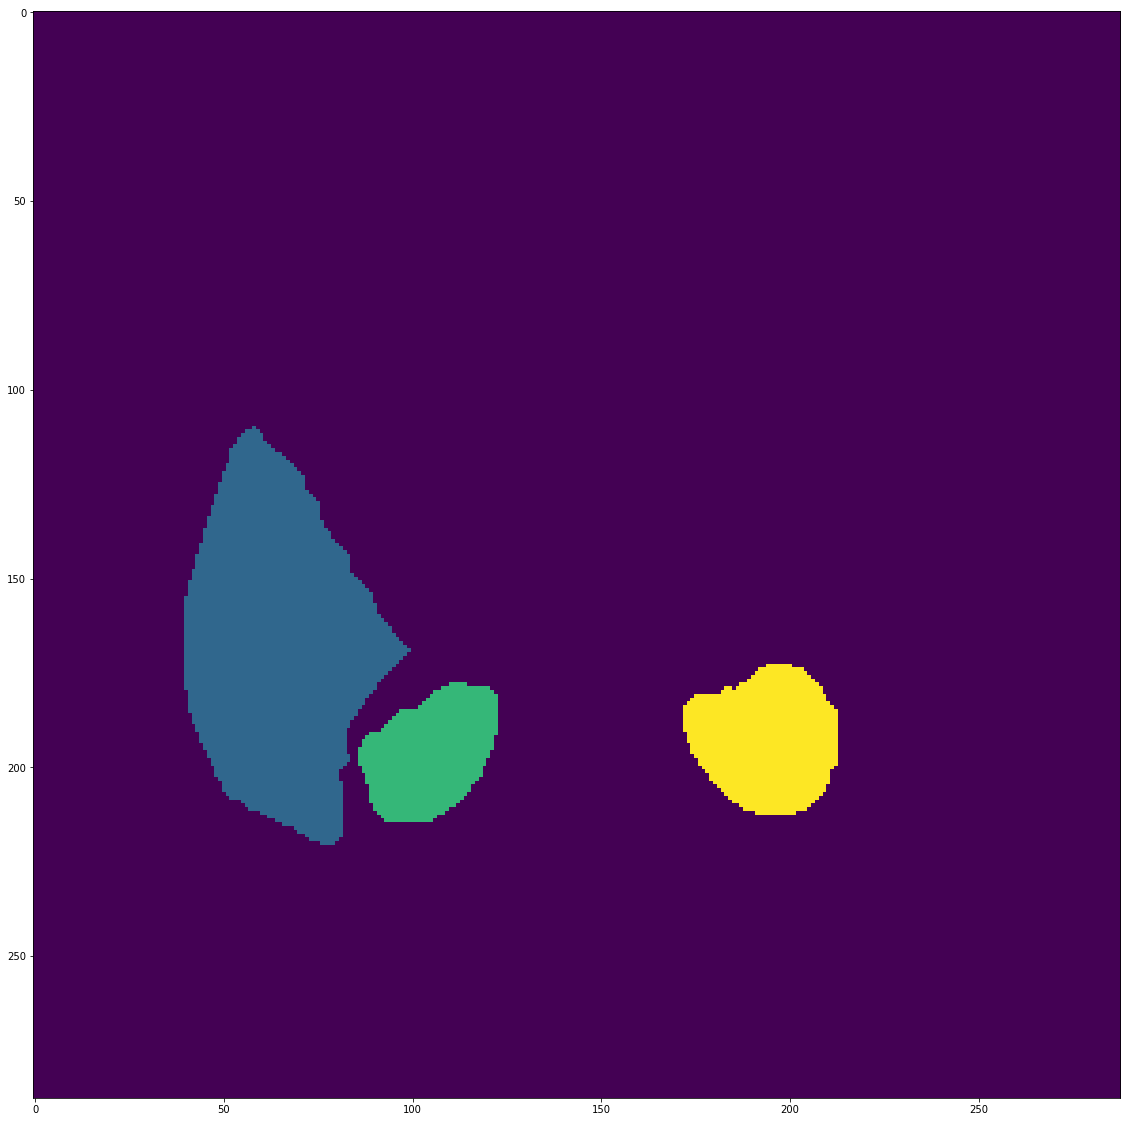

In [69]:
trl=imageio.imread(img_grnd.iloc[0])
plt.figure(figsize=(20,20))
plt.imshow(trl)

In [71]:
np.unique(trl)

Array([  0,  63, 126, 189], dtype=uint8)

In [33]:

def gen_text_gclm(window_size,angles_radian,offsets,file_list,file_info):
    
    """The purpose of this method is to act as a wrapper to generate a table of info on file"""
    #Ground Image
    one_image=bytescaling(imageio.imread(file_list[0].iloc[0]))#

    #Additoinal code here on file information required  
    grnd_img=imageio.imread(file_list[1].iloc[0])
    #iterating through different window size for estimating performance. 
    mask_intensities={0:'Background',63:'Liver',126:'r_kidney',189:'l_kidney',252:'spleen'}#,,

    for windows in window_size:

        patches=image.extract_patches_2d(one_image,windows)
        #print(patches.shape)
        grnd_patches=image.extract_patches_2d(grnd_img,windows)
        #print(grnd_patches.shape)
        
        for mask_intensity in mask_intensities:
            
            org_spec_patches,patch_idx=samp_mask(patches,grnd_patches,mask_intensity,sample_size_perc=0.001)
            #Getting central label of all index value from image. 
            #iterating through offsets to estimate performance. 
            
            for org_pat_num in range(0,len(org_spec_patches)-1):
                
                for offset in offsets:

                    grey_co_mat_cmds={'offset':offset,
                                     'angles':angles_radian,
                                     'levels':256,
                                     'symmetric':True,
                                     'normalised':True}

                    stat_list=gen_gclm(org_spec_patches[org_pat_num],**grey_co_mat_cmds)
                    #Creating final df to write to file
                    comp_stat_list=comp_array(stat_list)
                    file_name='Pat_id_'+str(file_info[0])+'img_typ_'+str(file_info[1])+'org_'+mask_intensities[mask_intensity]
                    file_name=file_name+'_slc_no_'+str(slc_no)+'patch_no'+str(patch_idx[org_pat_num])
                    file_name=file_name+'_WindS_'+str(windows[0])+'_OFS_'+str(offset[0])+'_4_ang_set'+'.pickle'
                    #Save to file
                    #print('save file name: ',file_name)
                    with open(file_name, 'wb') as handle:
                        #Dump pickle file 
                        pickle.dump(comp_stat_list, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [157]:
No_pers[5:10]

array([ 2, 20, 21, 22,  3], dtype=int64)

In [29]:
def remake_array(np_dict):
    """the purpose of this method is to rebuild numpy array based on initial values"""
    base_arr=np.zeros(np_dict['array_shape'],dtype=np_dict['dtype'])
    
    for vals in np_dict['non_zero_val_coord']:
        base_arr[vals[0],vals[1],vals[2],vals[3]]=vals[4]
        
    return base_arr

In [30]:
def comp_array(np_array):
    """The purpose of this method is to compress the GCLM matrices which are quite sparse into matrices that are 
    lower storagevalue"""
    #empty_dict
    empty_dict={}
    #Getting shape value for storage. 
    empty_dict['array_shape']=np_array.shape
    empty_dict['dtype']=str(np_array.dtype)
    
    #Get non zero value indeices
    np_iter=np_array.astype('float')
    x,y,z,l=np_array.nonzero()
    zip_coord=zip(x,y,z,l)
    
    #Getting non zero values stored to preserve space. 
    non_zero_coord_val=[]
    for tmp_x,tmp_y,tmp_z,tmp_l in zip_coord:
        tmp_val=np_array[tmp_x,tmp_y,tmp_z,tmp_l]
        
        tmp_tuple=(tmp_x,tmp_y,tmp_z,tmp_l,tmp_val)
        
        non_zero_coord_val.append(tmp_tuple)
        
    empty_dict['non_zero_val_coord']=non_zero_coord_val
    
    return empty_dict
        

## GCLM specific functions; patch wrapper and stats function

In [35]:
def gen_gclm(pat,**grey_co_mat_cmds):
    """The purpose of this method is to perform gclm analysis on patches"""
                    #Get cooccurence matrix for results. 
    tmp_gclm_info=greycomatrix(pat,grey_co_mat_cmds['offset'],
                               grey_co_mat_cmds['angles'],grey_co_mat_cmds['levels'],
                               symmetric=grey_co_mat_cmds['symmetric'],normed=grey_co_mat_cmds['normalised'])
    
    return tmp_gclm_info

In [36]:
def gen_gclm_stats(tmp_gclm_info,avrg_angle_vals=True):
    """The purpose of this method is to generate gcml within given set of parameters and copr"""

    #print('gclm shape',tmp_gclm_info.shape)
    #Averaging values across different radian angle values if averaging across angles for optimum performance. 
    if avrg_angle_vals==True:
        tmp_gclm_info=tmp_gclm_info.mean(axis=3,keepdims=True)
    #print('gclm shape post meanequalisation',tmp_gclm_info.shape)
    tmp_gclm_stats=np.array([greycoprops(tmp_gclm_info,"contrast"),
                           greycoprops(tmp_gclm_info,'dissimilarity'),
                           greycoprops(tmp_gclm_info,'homogeneity'),
                           greycoprops(tmp_gclm_info,'energy'),
                           greycoprops(tmp_gclm_info,'correlation'),
                           greycoprops(tmp_gclm_info,'ASM')])
    tmp_gclm_stats=tmp_gclm_stats.flatten('F')
    #print('tmp_gclm_stats shape: ',tmp_gclm_stats.shape)
    tmp_gclm_stats=tmp_gclm_stats.reshape((1,tmp_gclm_stats.shape[0]))
    return tmp_gclm_stats
    

In [37]:
def gen_greycomat_n_stats(ret_patch_list,
                     **grey_co_mat_cmds):
    """The purpose of this method is to find patches that are within the appropriate size range required.
    """
    #grey level property list
    gprop_stat_list=None
    gclm_list=[]
    #Iterating through patches. 
    for pat in ret_patch_list:
        
        tmp_gclm_info=gen_gclm(pat,**grey_co_mat_cmds)
        tmp_gclm_stats=gen_gclm_n_stats(tmp_gclm_info,avrg_angle_vals=True)
            #Append results in to alist for 
            
        if gprop_stat_list is None:
            gprop_stat_list=tmp_gclm_stats
        else:
            gprop_stat_list=np.concatenate((gprop_stat_list,tmp_gclm_stats))
            #print(gprop_stat_list.shape)   
    #Return gclm stat information to determine if texture image is best option. 
    return gprop_stat_list 


# Data set analysis

In [1]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 364B-7A6D

 Directory of C:\Users\niall\OneDrive\Documents\Data science masters\Thesis\Scripts\Python\Texture GCLM

26/08/2019  20:49    <DIR>          .
26/08/2019  20:49    <DIR>          ..
24/08/2019  13:19    <DIR>          .ipynb_checkpoints
19/08/2019  01:32            13,586 GCLM procedure.docx
26/08/2019  13:37            35,547 Texture extraction.ipynb
26/08/2019  20:49           286,886 Texture_features_EDA.ipynb
               3 File(s)        336,019 bytes
               3 Dir(s)  17,453,789,184 bytes free
